<a href="https://colab.research.google.com/github/kridtapon/WFO-HMA-STC/blob/main/WFO_HMA%2BSTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Hull Moving Average (HMA)
def hma(series, period):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))

    wma_half = series.rolling(window=half_length).apply(
        lambda x: np.dot(x, range(1, half_length + 1)) / sum(range(1, half_length + 1)), raw=True
    )
    wma_full = series.rolling(window=period).apply(
        lambda x: np.dot(x, range(1, period + 1)) / sum(range(1, period + 1)), raw=True
    )
    hma = (2 * wma_half - wma_full).rolling(window=sqrt_length).mean()
    return hma

# Function to calculate Schaff Trend Cycle (STC)
def calculate_stc(data, short_n, long_n, cycle_n):
    macd = data['Close'].ewm(span=short_n, adjust=False).mean() - data['Close'].ewm(span=long_n, adjust=False).mean()
    macd_signal = macd.ewm(span=cycle_n, adjust=False).mean()
    stc = (macd - macd_signal).ewm(span=cycle_n, adjust=False).mean()
    data['STC'] = stc
    return data

# Walk-forward optimization with dynamic parameter ranges
def walk_forward_optimization(df, start_year, end_year):
    results = []

    # Define dynamic ranges for parameters
    hma_short_period_range = range(1, 21, 2)
    hma_long_period_range = range(20, 41, 2)
    short_n_range = range(1, 16, 2)
    long_n_range = range(18, 31, 2)
    cycle_n_range = range(1, 15, 2)

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Use itertools to loop through all combinations dynamically
        for params in itertools.product(
            hma_short_period_range,
            hma_long_period_range,
            short_n_range,
            long_n_range,
            cycle_n_range
        ):
            hma_short_period, hma_long_period, short_n, long_n, cycle_n = params

            # Calculate indicators on the training data
            train_data = calculate_stc(train_data.copy(), short_n, long_n, cycle_n)
            train_data['HMA_Short'] = hma(train_data['Close'], hma_short_period)
            train_data['HMA_Long'] = hma(train_data['Close'], hma_long_period)

            # Generate entry and exit signals
            entries = (
                (train_data['STC'] > 0) &  # STC is positive
                (train_data['HMA_Short'] > train_data['HMA_Long'])  # Short HMA > Long HMA
            )
            exits = (
                (train_data['STC'] < 0) &  # STC is negative
                (train_data['HMA_Short'] < train_data['HMA_Long'])  # Short HMA < Long HMA
            )

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (hma_short_period, hma_long_period, short_n, long_n, cycle_n)

        # Test with the best parameters on the test data
        test_data = calculate_stc(test_data.copy(), best_params[2], best_params[3], best_params[4])
        test_data['HMA_Short'] = hma(test_data['Close'], best_params[0])
        test_data['HMA_Long'] = hma(test_data['Close'], best_params[1])

        entries = (
            (test_data['STC'] > 0) &  # STC is positive
            (test_data['HMA_Short'] > test_data['HMA_Long'])  # Short HMA > Long HMA
        )
        exits = (
            (test_data['STC'] < 0) &  # STC is negative
            (test_data['HMA_Short'] < test_data['HMA_Long'])  # Short HMA < Long HMA
        )

        portfolio = vbt.Portfolio.from_signals(
            close=test_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'FOXA'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']
    yearly_data = df[df.index.year == year]

    # Apply STC and HMA indicators
    yearly_data = calculate_stc(yearly_data, params[2], params[3], params[4])
    yearly_data['HMA_Short'] = hma(yearly_data['Close'], params[0])
    yearly_data['HMA_Long'] = hma(yearly_data['Close'], params[1])

    # Define entry/exit conditions
    entries = (yearly_data['STC'] > 0) & (yearly_data['HMA_Short'] > yearly_data['HMA_Long'])
    exits = (yearly_data['STC'] < 0) & (yearly_data['HMA_Short'] < yearly_data['HMA_Long'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed



Walk-Forward Optimization Results:
   Year          Best_Params
0  2020    (3, 40, 1, 24, 7)
1  2021    (3, 36, 1, 18, 5)
2  2022    (3, 36, 5, 20, 3)
3  2023  (5, 22, 15, 30, 13)
4  2024  (5, 22, 15, 28, 13)
5  2025  (7, 24, 15, 28, 13)


<ipython-input-11-7afd2ddabd2b>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-7afd2ddabd2b>:147: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-7afd2ddabd2b>:148: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-7a

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            149238.24708
Total Return [%]                        49.238247
Benchmark Return [%]                    40.703411
Max Gross Exposure [%]                      100.0
Total Fees Paid                      12376.876237
Max Drawdown [%]                        43.075813
Max Drawdown Duration                       725.0
Total Trades                                   43
Total Closed Trades                            42
Total Open Trades                               1
Open Trade PnL                       -3070.556687
Win Rate [%]                            30.952381
Best Trade [%]                          47.707636
Worst Trade [%]                        -10.032428
Avg Winning Trade [%]                    11.85467
Avg Losing Trade [%]                    -3.279502


<ipython-input-17-47538a489627>:4: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

<ipython-input-17-47538a489627>:8: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



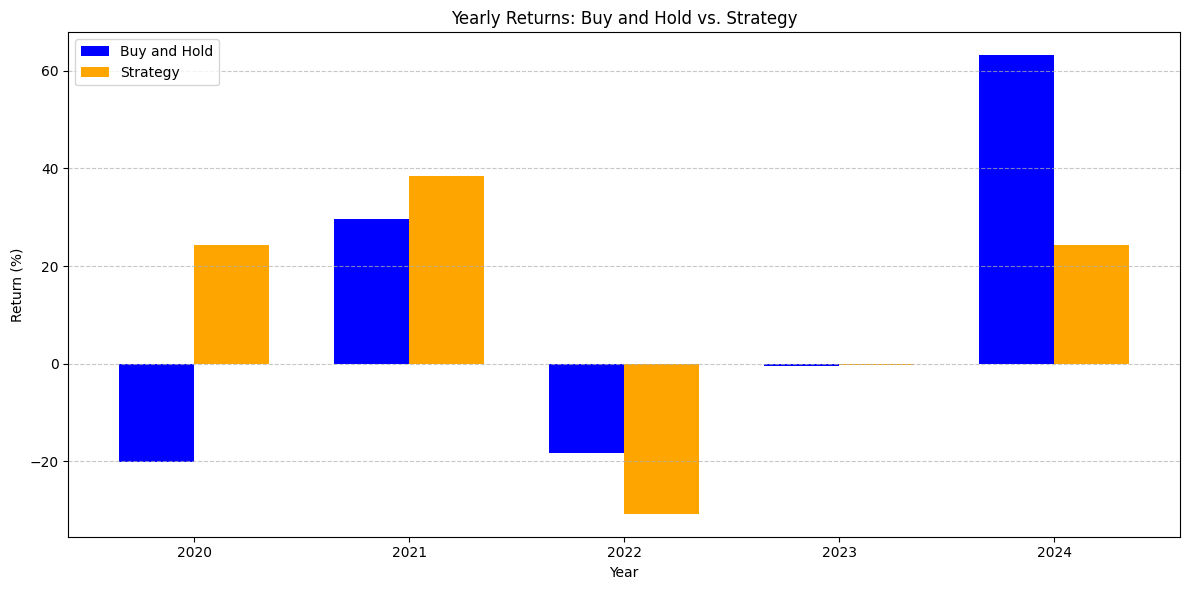

      Buy and Hold Return (%)  Strategy Return (%)
Date                                              
2020               -20.220553            24.307422
2021                29.619464            38.342444
2022               -18.253471           -30.761157
2023                -0.501103            -0.295471
2024                63.173231            24.388967


In [17]:
import matplotlib.pyplot as plt

# Calculate buy-and-hold returns for each year
buy_and_hold_returns = df['Close'].resample('Y').last() / df['Close'].resample('Y').first() - 1
buy_and_hold_returns.index = buy_and_hold_returns.index.year

# Calculate yearly returns of the strategy
strategy_yearly_returns = portfolio.returns().resample('Y').sum()
strategy_yearly_returns.index = strategy_yearly_returns.index.year

# Align data for plotting
common_years = buy_and_hold_returns.index.intersection(strategy_yearly_returns.index)
buy_and_hold_returns = buy_and_hold_returns[common_years]
strategy_yearly_returns = strategy_yearly_returns[common_years]

# Create bar chart
plt.figure(figsize=(12, 6))
width = 0.35
years = common_years

plt.bar([year - width / 2 for year in years], buy_and_hold_returns * 100, width=width, label='Buy and Hold', color='blue')
plt.bar([year + width / 2 for year in years], strategy_yearly_returns * 100, width=width, label='Strategy', color='orange')

plt.title('Yearly Returns: Buy and Hold vs. Strategy')
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.xticks(years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print yearly returns for comparison
comparison_df = pd.DataFrame({
    'Buy and Hold Return (%)': buy_and_hold_returns * 100,
    'Strategy Return (%)': strategy_yearly_returns * 100
})
print(comparison_df)


In [23]:
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,140703.41121
Total Return [%],40.703411
Benchmark Return [%],40.703411
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],48.28233
